In [1]:
# import bw2io as bi

In [2]:
# bi.restore_project_directory('/Users/timodiepers/Documents/Coding/brightway2-project-bw25_premise_background_v2-backup.26-March-2024-01-40PM.tar.gz', overwrite_existing=True, project_name='bw25_premise')

In [3]:
import bw2data as bd

In [4]:
bd.projects.set_current('bw25_premise')

In [5]:
db_2020 = bd.Database("db_2020")
db_2030 = bd.Database("db_2030")
db_2040 = bd.Database("db_2040")

In [6]:
del bd.databases['foreground']

In [7]:
ev_background = [x for x in db_2020 if (x['name'] == 'transport, passenger car, electric')][0]
ev_background

'transport, passenger car, electric' (kilometer, GLO, None)

In [8]:
[e for e in ev_background.exchanges()]

In [9]:
foreground = bd.Database("foreground")
foreground.write({})

In [10]:
ev = ev_background.copy(name="copy of transport, passenger car, electric")

In [11]:
ev['database'] = 'foreground'

Successfully switch activity dataset to database `foreground`


In [12]:
ev.save()

In [13]:
[e for e in ev.exchanges()]

[Exchange: 1.0 kilometer 'copy of transport, passenger car, electric' (kilometer, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -1.050395781021507e-06 kilogram 'market for brake wear emissions, passenger car' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -1.155435347754974e-05 kilogram 'market for road wear emissions, passenger car' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -0.0026199999265372753 kilogram 'market for used Li-ion battery' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -6.756759830750525e-05 kilogram 'market for tyre wear emissions, passenger car' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: 0.00048747999244369566 meter-year 'market for road' (meter-year, GLO, None) to 'copy of trans

In [14]:
from bw_temporalis import TemporalDistribution
import numpy as np

# defining Temporal Distributions of system
td_production = TemporalDistribution(
            date=np.array([-1], dtype='timedelta64[Y]'), #2023
            amount=np.array([1]))

td_use_phase = TemporalDistribution( #to be further refined based on use pattern
                    date=np.array([1, 6, 11, 16], dtype='timedelta64[Y]'), #2025, 2030, 2035, 2040
                    amount=np.array([0.25, 0.25, 0.25, 0.25]))

td_eol = TemporalDistribution(
            date=np.array([21], dtype='timedelta64[Y]'), #2045
            amount=np.array([1]))

td_eol_from_production_time = TemporalDistribution(
            date=np.array([22], dtype='timedelta64[Y]'), #2045, counting from 2023
            amount=np.array([1]))

In [15]:
#add TD to electricity and car production
for exc in ev.exchanges():
    if "market for battery, Li-ion"in exc.input["name"]: #battery production
        exc["temporal_distribution"]= td_production
        exc.save()
        print("added TD to ", {exc.input["name"]})

    elif "market for passenger car, electric, without battery"in exc.input["name"]: # foreground car production
        exc["temporal_distribution"]= td_production
        exc.save()
        print("added TD to ", {exc.input["name"]})

    elif "market group for electricity, low voltage" in exc.input["name"]: #electricity while driving
        exc["temporal_distribution"]= td_use_phase
        exc.save()
        print("added TD to ", {exc.input["name"]})

    elif "market for used Li-ion battery" in exc.input["name"]:   #battery recycling
        exc["temporal_distribution"]= td_eol
        exc.save()
        print("added TD to ", {exc.input["name"]})

    elif "wear emissions, passenger car" in exc.input["name"]: #brake, road and tyre wear while driving
        exc["temporal_distribution"]= td_use_phase
        exc.save()
        print("added TD to ", {exc.input["name"]})
    
    elif "market for maintenance, passenger car" in exc.input["name"]: #car maintenance while driving
        exc["temporal_distribution"]= td_use_phase
        exc.save()
        print("added TD to ", {exc.input["name"]})
            
    elif exc.input["name"] == "market for road": # road usage while driving
        exc["temporal_distribution"]= td_use_phase
        exc.save()
        print("added TD to ", {exc.input["name"]})
    
    elif exc.input["name"] == exc.output["name"]: #skip production exchange
        continue

    else:
        print("no TD added to ", {exc.input["name"]})

    # car recycling is modelled at the level of car production, and TD is added there

added TD to  {'market for brake wear emissions, passenger car'}
added TD to  {'market for road wear emissions, passenger car'}
added TD to  {'market for used Li-ion battery'}
added TD to  {'market for tyre wear emissions, passenger car'}
added TD to  {'market for road'}
added TD to  {'market for battery, Li-ion, LiMn2O4, rechargeable, prismatic'}
added TD to  {'market for maintenance, passenger car, electric, without battery'}
added TD to  {'market for passenger car, electric, without battery'}
added TD to  {'market group for electricity, low voltage'}


In [16]:
method = ('IPCC 2021 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [17]:
from datetime import datetime

database_date_dict = {
    "db_2020": datetime.strptime("2020", "%Y"),
    "db_2030": datetime.strptime("2030", "%Y"),
    "db_2040": datetime.strptime("2040", "%Y"),
    # "cutoff39": datetime.strptime("2020", "%Y"), # all databases need to have a corresponding time
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

In [18]:
from timex_lca import TimexLCA
mlca = TimexLCA({ev.key: 1}, method, None, database_date_dict) #aborted after 100 min for max_calc = 5000


Calculation count: 5


In [19]:
mlca.build_timeline()

,hash_producer,time_mapped_producer,date_producer,producer,producer_name,hash_consumer,time_mapped_consumer,date_consumer,consumer,consumer_name,amount,interpolation_weights
0,2023,98285,2023-01-01,35045,"market for battery, Li-ion, LiMn2O4, rechargea...",2024,98287,2024-01-01,98284,"copy of transport, passenger car, electric",0.00262,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
1,2023,98286,2023-01-01,43696,"market for passenger car, electric, without ba...",2024,98287,2024-01-01,98284,"copy of transport, passenger car, electric",0.006121,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
2,2024,98287,2024-01-01,98284,"copy of transport, passenger car, electric",2024,-1,2024-01-01,-1,-1,1.0,"{'db_2020': 0.6000547495209416, 'db_2030': 0.3..."
3,2025,98288,2025-01-01,31847,market for road,2024,98287,2024-01-01,98284,"copy of transport, passenger car, electric",0.000122,"{'db_2020': 0.4998631261976457, 'db_2030': 0.5..."
4,2025,98289,2025-01-01,40481,"market for maintenance, passenger car, electri...",2024,98287,2024-01-01,98284,"copy of transport, passenger car, electric",0.000002,"{'db_2020': 0.4998631261976457, 'db_2030': 0.5..."
5,2025,98290,2025-01-01,50069,"market group for electricity, low voltage",2024,98287,2024-01-01,98284,"copy of transport, passenger car, electric",0.04975,"{'db_2020': 0.4998631261976457, 'db_2030': 0.5..."
6,2030,98291,2030-01-01,31847,market for road,2024,98287,2024-01-01,98284,"copy of transport, passenger car, electric",0.000122,{'db_2030': 1}
7,2030,98292,2030-01-01,40481,"market for maintenance, passenger car, electri...",2024,98287,2024-01-01,98284,"copy of transport, passenger car, electric",0.000002,{'db_2030': 1}
8,2030,98293,2030-01-01,50069,"market group for electricity, low voltage",2024,98287,2024-01-01,98284,"copy of transport, passenger car, electric",0.04975,{'db_2030': 1}
9,2035,98294,2035-01-01,31847,market for road,2024,98287,2024-01-01,98284,"copy of transport, passenger car, electric",0.000122,"{'db_2030': 0.5, 'db_2040': 0.5}"


In [20]:
mlca.build_datapackage()
mlca.lci()
mlca.lcia()

In [21]:
mlca.create_labelled_technosphere_dataframe()

,"((db_2020, 0000845fede810c891788763310005db), 2020)","((db_2020, 000246fec6ba3180d44719c8a58f94ee), 2020)","((db_2020, 0002bb27891915b306bed66b596f4345), 2020)","((db_2020, 000443ca0743c972594a6236c29ac4c7), 2020)","((db_2020, 000860bc617c5e3ce369f5736abbfab1), 2020)","((db_2020, 00111b793f3b554d6976e765c9272b39), 2020)","((db_2020, 0012da481fe8d7533ec8584362469d16), 2020)","((db_2020, 001974f7bfeddf21e6642b3344948da1), 2020)","((db_2020, 001bfd4d97e6088bd288a652ca92da5c), 2020)","((db_2020, 001c48b2b858bc3088ece60e3828d235), 2020)",...,"((db_2020, fec93a95a9a84d7fa0ede9c3082bb79f), 2025)","((db_2020, 464f67b3c32dc2735beab79c8117b91f), 2030)","((db_2020, adffc79f1159744571b425ae33d060bf), 2030)","((db_2020, fec93a95a9a84d7fa0ede9c3082bb79f), 2030)","((db_2020, 464f67b3c32dc2735beab79c8117b91f), 2035)","((db_2020, adffc79f1159744571b425ae33d060bf), 2035)","((db_2020, fec93a95a9a84d7fa0ede9c3082bb79f), 2035)","((db_2020, 464f67b3c32dc2735beab79c8117b91f), 2040)","((db_2020, adffc79f1159744571b425ae33d060bf), 2040)","((db_2020, fec93a95a9a84d7fa0ede9c3082bb79f), 2040)"
"((db_2020, 0000845fede810c891788763310005db), 2020)",1.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"((db_2020, 000246fec6ba3180d44719c8a58f94ee), 2020)",0.0,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"((db_2020, 0002bb27891915b306bed66b596f4345), 2020)",0.0,0.0,0.999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"((db_2020, 000443ca0743c972594a6236c29ac4c7), 2020)",0.0,0.0,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"((db_2020, 000860bc617c5e3ce369f5736abbfab1), 2020)",0.0,0.0,0.000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"((db_2020, adffc79f1159744571b425ae33d060bf), 2035)",0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"((db_2020, fec93a95a9a84d7fa0ede9c3082bb79f), 2035)",0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"((db_2020, 464f67b3c32dc2735beab79c8117b91f), 2040)",0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"((db_2020, adffc79f1159744571b425ae33d060bf), 2040)",0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:

mlca.create_labelled_dynamic_biosphere_dataframe()

,"((db_2020, 0000845fede810c891788763310005db), 2020)","((db_2020, 000246fec6ba3180d44719c8a58f94ee), 2020)","((db_2020, 0002bb27891915b306bed66b596f4345), 2020)","((db_2020, 000443ca0743c972594a6236c29ac4c7), 2020)","((db_2020, 000860bc617c5e3ce369f5736abbfab1), 2020)","((db_2020, 00111b793f3b554d6976e765c9272b39), 2020)","((db_2020, 0012da481fe8d7533ec8584362469d16), 2020)","((db_2020, 001974f7bfeddf21e6642b3344948da1), 2020)","((db_2020, 001bfd4d97e6088bd288a652ca92da5c), 2020)","((db_2020, 001c48b2b858bc3088ece60e3828d235), 2020)",...,"((db_2020, fec93a95a9a84d7fa0ede9c3082bb79f), 2025)","((db_2020, 464f67b3c32dc2735beab79c8117b91f), 2030)","((db_2020, adffc79f1159744571b425ae33d060bf), 2030)","((db_2020, fec93a95a9a84d7fa0ede9c3082bb79f), 2030)","((db_2020, 464f67b3c32dc2735beab79c8117b91f), 2035)","((db_2020, adffc79f1159744571b425ae33d060bf), 2035)","((db_2020, fec93a95a9a84d7fa0ede9c3082bb79f), 2035)","((db_2020, 464f67b3c32dc2735beab79c8117b91f), 2040)","((db_2020, adffc79f1159744571b425ae33d060bf), 2040)","((db_2020, fec93a95a9a84d7fa0ede9c3082bb79f), 2040)"
"(38a622c6-f086-4763-a952-7c6b3b1c42ba, 2023-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
"(541a823c-0aad-4dc4-9123-d4af4647d942, 2023-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
"(8cbaa905-41b0-4327-8403-bf1c8eb25429, 2023-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
"(f681eb3c-854a-4f78-bcfe-76dfbcf9df3c, 2023-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
"(a0fec60d-3f74-48bf-a2d2-58c30fc13e53, 2023-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(ddd99a3a-be86-423d-b36a-a9dc8af1b1f8, 2040-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.316593e-12,1.515790e-10,1.345962e-13
"(21e46cb8-6233-4c99-bac3-c41d2ab99498, 2040-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.101605e-03,1.587941e-02,4.218233e-06
"(295c9740-6fdb-4676-9eb8-15e3786f713d, 2040-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.013540e-03,6.659191e-02,2.138521e-05
"(5716c728-bd33-414d-8691-16e5534f5d37, 2040-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.333540e-05,1.540927e-01,2.407989e-06


In [23]:
co2_flows = [flow for flow in bd.Database('biosphere3') if 'Carbon dioxide' in flow['name'] and "air" in flow['categories']]

In [24]:
co2_flow_codes = [flow['code'] for flow in co2_flows]

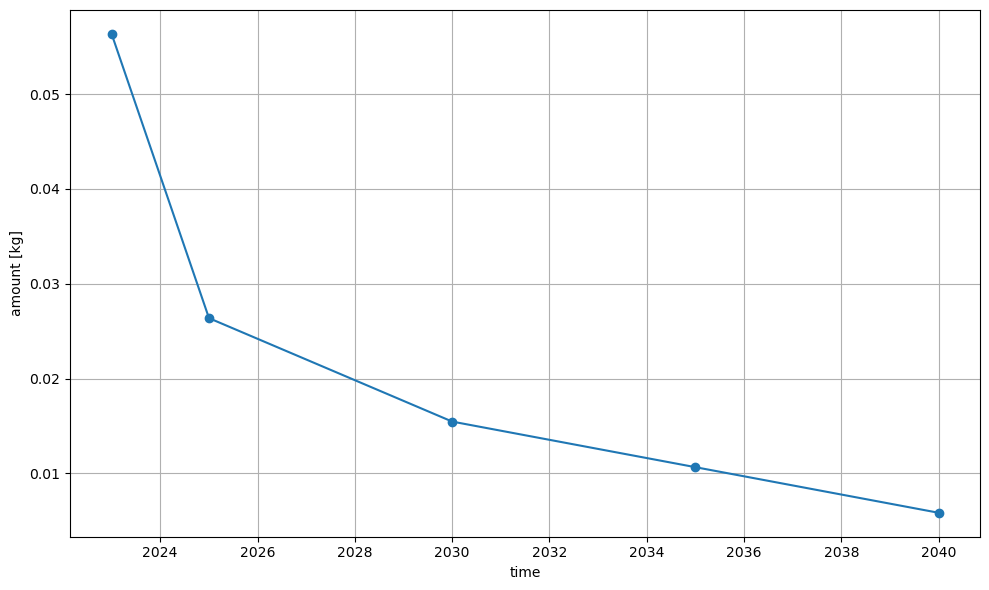

In [25]:
mlca.plot_dynamic_inventory(bio_flows=co2_flow_codes)

In [26]:
from timex_lca.utils import add_flows_to_characterization_function_dict
from timex_lca.dynamic_characterization import characterize_co2

In [27]:
co2_flow_ids = [flow.id for flow in co2_flows]

In [28]:
cf_dict = add_flows_to_characterization_function_dict(co2_flow_ids, characterize_co2)

In [29]:
mlca.characterize_dynamic_lci(type="radiative_forcing", fixed_TH = False, characterization_functions=cf_dict)

/Users/timodiepers/Documents/Coding/timex/timex_lca/dynamic_characterization.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  inventory_as_dataframe = pd.concat(dfs, ignore_index=True)
/Users/timodiepers/Documents/Coding/timex/timex_lca/dynamic_characterization.py:157: UserWarning: If there is no dynamic characterization function for a flow, the flow will be ingored.
  warnings.warn(


,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,2023-01-01 00:00:00,0.000000e+00,112,"Carbon dioxide, fossil",98285.0,"(db_2020, 6bf26a8d0923502e6e5a2700be96a866)",0.000000e+00
19,2023-01-01 00:00:00,0.000000e+00,3642,"Carbon dioxide, from soil or biomass stock",98285.0,"(db_2020, 6bf26a8d0923502e6e5a2700be96a866)",0.000000e+00
18,2023-01-01 00:00:00,0.000000e+00,1168,"Carbon dioxide, fossil",98286.0,"(db_2020, d555fddc42de6c636364ae4eeb4b391f)",0.000000e+00
17,2023-01-01 00:00:00,0.000000e+00,112,"Carbon dioxide, fossil",98286.0,"(db_2020, d555fddc42de6c636364ae4eeb4b391f)",0.000000e+00
16,2023-01-01 00:00:00,0.000000e+00,1164,"Carbon dioxide, non-fossil",98286.0,"(db_2020, d555fddc42de6c636364ae4eeb4b391f)",0.000000e+00
...,...,...,...,...,...,...,...
13971,2139-01-01 00:10:48,3.071216e-19,112,"Carbon dioxide, fossil",98298.0,"(db_2020, adffc79f1159744571b425ae33d060bf)",1.015424e-14
13970,2139-01-01 00:10:48,1.502607e-21,3642,"Carbon dioxide, from soil or biomass stock",98298.0,"(db_2020, adffc79f1159744571b425ae33d060bf)",1.015393e-14
13998,2139-01-01 00:10:48,5.994099e-26,1169,"Carbon dioxide, fossil",98298.0,"(db_2020, adffc79f1159744571b425ae33d060bf)",1.015797e-14
13983,2139-01-01 00:10:48,1.266081e-23,3632,"Carbon dioxide, from soil or biomass stock",98297.0,"(db_2020, 464f67b3c32dc2735beab79c8117b91f)",1.015621e-14


/Users/timodiepers/anaconda3/envs/medusa/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/timodiepers/anaconda3/envs/medusa/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/timodiepers/anaconda3/envs/medusa/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/timodiepers/anaconda3/envs/medusa/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

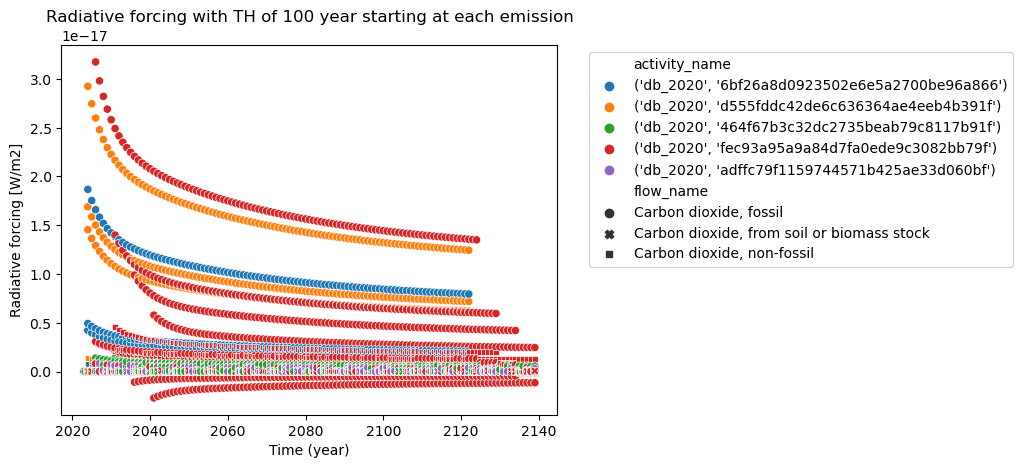

In [30]:
mlca.plot_dynamic_characterized_inventory()